## **Advanced Analyitcs and Applications - Data Collection Strategy**

This Jupyter notebook `01_Data_Preparation.ipynb` is the first step in the "Advanced Analytics and Application" team project. Its primary purpose is to handle the initial data collection and preparation tasks. This includes:

* Setting up the Python environment and importing necessary libraries.
* Loading project configurations, including API keys and file paths.
* Fetching taxi trip data from the City of Chicago data portal using a custom API client `src/api/taxi.py`.
* Fetching weather data for Chicago using a custom API client `src/api/weather.py` for a relevant period.
* Storing the raw fetched data for subsequent processing and analysis.

The data collected here will form the basis for descriptive analytics, predictive modeling, and reinforcement learning tasks outlined in the project assignment.

##### **Table of Contents**

0. [Notebook Setup](#Notebook-Set-Up-and-Imports)
1. [Data Collection](#Data-Collection)
1.1. [Taxi Data Collection](#Taxi-Data)
1.2. [Weather Data Collection](#Weather-Data)
3. [References](#References)

##### **Notebook Set Up and Imports**

In [1]:
%%html
<style>
.dataframe th {
    font-family: "JetBrainsMono Nerd Font";
}
.dataframe td {
    font-family: "JetBrainsMono Nerd Font";
}
</style>

In [2]:
import importlib
import os
import pickle
import subprocess
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sns
import yaml

Matplotlib is building the font cache; this may take a moment.


In [3]:
sys.path.append(str(Path.cwd().parent))
from src.utils.notebook_setup import load_files, setup_notebook

style_manager = setup_notebook()

if str(Path().resolve()).split("/")[-1] == "AAA":
    print("already set repo root")
else:
    notebooks_dir = Path().resolve()
    repo_root = notebooks_dir.parent
    config_dir = repo_root / "config"
    data_dir = repo_root / "data"
    results_dir = data_dir / "results"
    raw_data_dir = data_dir / "raw"
    processed_data_dir = data_dir / "processed"

    with open(config_dir / "config.yaml", "r") as file:
        config = yaml.safe_load(file)
    
    os.chdir(repo_root)

## Data Collection
[Back to Table of Contents](#Table-of-Contents)

### Taxi Data

This section focuses on acquiring taxi trip data from the City of Chicago's Socrata open data portal. This is achieved using a custom-built API client.

**API Client Initialization**:

The ChicagoTaxiAPI class, defined in `src.api.taxi.py`. An instance of the ChicagoTaxiAPI is created. The necessary Socrata App Token for accessing the Chicago Taxi dataset is retrieved from the previously loaded config object (specifically from `config["CHICAGO_TAXI"].get("APP_TOKEN", None)`). Using an `APP_TOKEN` is crucial for avoiding strict rate limits imposed on unauthenticated API requests.

In [4]:
from src.api.taxi import ChicagoTaxiAPI

api = ChicagoTaxiAPI(
    app_token=config["CHICAGO_TAXI"].get("APP_TOKEN", None)
)

df_sample = api.fetch_data(
    select = (
        "trip_id, taxi_id, trip_start_timestamp, trip_end_timestamp, trip_seconds, "
        "trip_miles, pickup_census_tract, dropoff_census_tract, pickup_community_area, "
        "dropoff_community_area, fare, tips, tolls, extras, trip_total, payment_type, "
        "company, pickup_centroid_location, dropoff_centroid_location"
    ),
    where=(
        "pickup_centroid_location IS NOT NULL "
        "AND dropoff_centroid_location IS NOT NULL "
        "AND trip_start_timestamp IS NOT NULL "
        "AND trip_start_timestamp >= '2025-05-01T00:00:00' "
        "AND trip_start_timestamp <= '2025-05-02T00:00:00' "
    ),
    order="trip_start_timestamp DESC",
    limit=300_000,
)

api.close()

In [5]:
df_sample
df_sample.info()
df_sample.head()
df_sample.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29 entries, 0 to 28
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   trip_id                    29 non-null     string        
 1   taxi_id                    29 non-null     string        
 2   trip_start_timestamp       29 non-null     datetime64[ns]
 3   trip_end_timestamp         29 non-null     datetime64[ns]
 4   trip_seconds               29 non-null     int64         
 5   trip_miles                 29 non-null     float64       
 6   pickup_community_area      29 non-null     int64         
 7   dropoff_community_area     29 non-null     int64         
 8   fare                       29 non-null     float64       
 9   tips                       29 non-null     float64       
 10  tolls                      29 non-null     int64         
 11  extras                     29 non-null     float64       
 12  trip_total

,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_community_area,dropoff_community_area,fare,tips,tolls,extras,trip_total
count,29,29,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.0,29.000000,29.000000
mean,2025-05-01 00:00:00,2025-05-01 00:12:24.827586304,1031.482759,10.222759,47.241379,22.551724,27.191724,3.212069,0.0,3.051724,33.645172
min,2025-05-01 00:00:00,2025-05-01 00:00:00,180.000000,0.300000,3.000000,2.000000,4.000000,0.000000,0.0,0.000000,4.500000
25%,2025-05-01 00:00:00,2025-05-01 00:15:00,753.000000,6.040000,8.000000,8.000000,17.610000,0.000000,0.0,0.000000,24.000000
50%,2025-05-01 00:00:00,2025-05-01 00:15:00,1123.000000,10.770000,56.000000,17.000000,28.250000,0.000000,0.0,4.000000,29.750000
75%,2025-05-01 00:00:00,2025-05-01 00:15:00,1267.000000,14.680000,76.000000,32.000000,36.250000,7.000000,0.0,4.000000,45.250000
max,2025-05-01 00:00:00,2025-05-01 00:30:00,1973.000000,24.280000,76.000000,76.000000,59.000000,12.900000,0.0,23.000000,77.400000
std,NaN,NaN,473.953254,6.103610,29.159237,19.395482,13.692488,4.244521,0.0,4.428691,18.801253


In [7]:
import folium
import geopandas as gpd
from shapely.geometry import LineString
from IPython.display import display

# Rebuild geometry
df_sample["geometry"] = df_sample.apply(
    lambda row: LineString([
        row["pickup_centroid_location"]["coordinates"],
        row["dropoff_centroid_location"]["coordinates"]
    ]) if row["pickup_centroid_location"] and row["dropoff_centroid_location"] else None,
    axis=1
)
gdf = gpd.GeoDataFrame(df_sample, geometry="geometry", crs="EPSG:4326").dropna(subset=["geometry"])

# Center map on chicago
m = folium.Map(location=[41.8781, -87.6298], zoom_start=11)

# Add trip lines
for line in gdf["geometry"]:
    folium.PolyLine(
        locations=[(lat, lon) for lon, lat in line.coords],
        color="blue", weight=2, opacity=0.5
    ).add_to(m)

# Add pickup and dropoff markers
for _, row in gdf.iterrows():
    pickup_coords = row["pickup_centroid_location"]["coordinates"]
    dropoff_coords = row["dropoff_centroid_location"]["coordinates"]
    
    folium.CircleMarker(
        location=(pickup_coords[1], pickup_coords[0]),  # lat, lon
        radius=4,
        color="green",
        fill=True,
        fill_color="green",
        fill_opacity=0.7,
        popup=f"Pickup: {row['trip_start_timestamp']}"
    ).add_to(m)
    
    folium.CircleMarker(
        location=(dropoff_coords[1], dropoff_coords[0]),  # lat, lon
        radius=4,
        color="red",
        fill=True,
        fill_color="red",
        fill_opacity=0.7,
        popup=f"Dropoff: {row['trip_end_timestamp']}"
    ).add_to(m)

# Show map in notebook
display(m)

In [9]:
raw_data_dir.mkdir(parents=True, exist_ok=True)

df_batch_sample = api.fetch_batch_data(
    select = (
        "trip_id, taxi_id, trip_start_timestamp, trip_end_timestamp, trip_seconds, "
        "trip_miles, pickup_census_tract, dropoff_census_tract, pickup_community_area, "
        "dropoff_community_area, fare, tips, tolls, extras, trip_total, payment_type, "
        "company, pickup_centroid_location, dropoff_centroid_location"
    ),
    where=(
        "pickup_centroid_location IS NOT NULL "
        "AND dropoff_centroid_location IS NOT NULL "
        "AND trip_start_timestamp <= trip_end_timestamp "
        "AND trip_start_timestamp IS NOT NULL"
    ), 
    output_dir=raw_data_dir, records_to_fetch=100000, batch_size=50000

)

Fetching all data:   0%|          | 0/100000 [00:00<?, ?rec/s]

Fetching all data: 100%|██████████| 100000/100000 [02:15<00:00, 739.63rec/s]


🔗 Combining all fetched batches...
⚙️ Applying type conversions to combined data...
✅ Total data fetched: 100,000 records.


In [10]:
df_batch_sample

,trip_id,taxi_id,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_community_area,dropoff_community_area,fare,tips,tolls,extras,trip_total,payment_type,company,pickup_centroid_location,dropoff_centroid_location,pickup_census_tract,dropoff_census_tract
0,528ef1a98b355a991a622ea6ca8ccea04a645c11,ddc0a237498a82a0803761188d0ea048623b5d91f29ad2...,2025-05-01 00:00:00,2025-05-01 00:15:00,1246.0,15.58,76.0,24.0,38.50,7.00,0.0,4.0,50.00,Credit Card,5 Star Taxi,"{'type': 'Point', 'coordinates': [-87.91362459...","{'type': 'Point', 'coordinates': [-87.67635598...",<NA>,<NA>
1,a944e871d44b0fe8d8759ea011ee114c6b4c47d8,3b4da267511934cb42da9f200f346b4719f5d5d761e0a5...,2025-05-01 00:00:00,2025-05-01 00:15:00,753.0,6.04,8.0,6.0,17.61,0.00,0.0,0.0,18.11,Mobile,Flash Cab,"{'type': 'Point', 'coordinates': [-87.63330803...","{'type': 'Point', 'coordinates': [-87.65599818...",<NA>,<NA>
2,8ac39e05667c980aca6a30c386833acc8f63f302,ef7488a67b3bdf0eaa5355fbfba3dc68a90b9a1f84547f...,2025-05-01 00:00:00,2025-05-01 00:15:00,835.0,7.11,76.0,9.0,19.50,0.00,0.0,5.0,24.50,Cash,Sun Taxi,"{'type': 'Point', 'coordinates': [-87.91362459...","{'type': 'Point', 'coordinates': [-87.81378103...",<NA>,<NA>
3,bf14c426e3958e27ff8087c054d6fdb334f1a1c2,f20c9c5845dab1e51799b959d378c102763d4b31d738da...,2025-05-01 00:00:00,2025-05-01 00:15:00,1123.0,10.55,32.0,44.0,28.00,0.00,0.0,0.0,28.00,Prcard,Flash Cab,"{'type': 'Point', 'coordinates': [-87.62519214...","{'type': 'Point', 'coordinates': [-87.61596952...",<NA>,<NA>
4,3592419fe47b3f8b8c6e9df61d50421dd71a32e1,f32c0c8e63d4e5d4bfc7e9d57e5d0f6dcf28450850245d...,2025-05-01 00:00:00,2025-05-01 00:15:00,1560.0,12.70,76.0,2.0,33.25,7.55,0.0,4.0,44.80,Credit Card,Taxi Affiliation Services,"{'type': 'Point', 'coordinates': [-87.91362459...","{'type': 'Point', 'coordinates': [-87.69501258...",<NA>,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,5f082d1701430307bfb89f0e41a90a815fbe4047,a0a66f6e978125e040111831d60457ff2551356865bd69...,2025-04-25 16:00:00,2025-04-25 16:15:00,1048.0,2.42,8.0,8.0,11.25,2.00,0.0,0.0,13.75,Credit Card,Medallion Leasin,"{'type': 'Point', 'coordinates': [-87.62621490...","{'type': 'Point', 'coordinates': [-87.64990722...",17031081500,17031842200
99996,7d11a4c3741314f19e329857f2201b0511a56b4e,d7c3e45884528f9dfd9902265c2c90a2bf848619f3c68d...,2025-04-25 16:00:00,2025-04-25 16:15:00,745.0,2.73,33.0,32.0,11.25,4.00,0.0,0.0,15.75,Credit Card,Chicago Independents,"{'type': 'Point', 'coordinates': [-87.61735800...","{'type': 'Point', 'coordinates': [-87.62099291...",17031330100,17031320100
99997,d9c84450807d892aad882cddebe61b5a662a955d,36add30222345794b60adf964631e6a1994b1a77c74105...,2025-04-25 16:00:00,2025-04-25 16:15:00,348.0,0.37,8.0,8.0,5.25,0.00,0.0,0.0,5.25,Cash,Sun Taxi,"{'type': 'Point', 'coordinates': [-87.62076286...","{'type': 'Point', 'coordinates': [-87.61971067...",17031081300,17031081401
99998,bdd29a36490d76ac59a3dbc7e025eca5c4ddec9a,4fd6cc40972b7fd3e026723f0fc4928d7f3159ea0e0822...,2025-04-25 16:00:00,2025-04-25 16:45:00,2400.0,9.90,46.0,38.0,30.00,0.00,0.0,0.0,30.00,Unknown,Taxi Affiliation Services,"{'type': 'Point', 'coordinates': [-87.55142819...","{'type': 'Point', 'coordinates': [-87.61785967...",<NA>,<NA>


In [11]:
from src.api.weather import ChicagoWeatherAPI
from datetime import date
import pandas as pd

weather_api = ChicagoWeatherAPI()

from src.api.weather import ChicagoWeatherAPI
import pandas as pd

start_date = df_batch_sample['trip_start_timestamp'].min().date()
end_date = df_batch_sample['trip_start_timestamp'].max().date()

print(f"Fetching weather data from {start_date} to {end_date}...")

weather_api = ChicagoWeatherAPI()

historical_df = weather_api.get_historical_weather(
    start_date=start_date.strftime("%Y-%m-%d"),
    end_date=end_date.strftime("%Y-%m-%d"),
    hourly_vars=["temperature_2m", "precipitation", "weather_code", "wind_speed_10m"],
    daily_vars=["temperature_2m_max", "temperature_2m_min", "precipitation_sum"]
)

forecast_df = weather_api.get_forecast_weather(
    days=3,
    hourly_vars=["temperature_2m", "apparent_temperature", "precipitation_probability"],
    daily_vars=["sunrise", "sunset", "uv_index_max"]
)

weather_api.close()

historical_df = historical_df.reset_index()
historical_df.rename(columns={'time': 'datetime'}, inplace=True)
historical_df['datetime'] = pd.to_datetime(historical_df['datetime'])
historical_df['hour'] = historical_df['datetime'].dt.hour
historical_df['date'] = historical_df['datetime'].dt.date

forecast_df = forecast_df.reset_index()
forecast_df.rename(columns={'time': 'datetime'}, inplace=True)
forecast_df['datetime'] = pd.to_datetime(forecast_df['datetime'])
forecast_df['hour'] = forecast_df['datetime'].dt.hour
forecast_df['date'] = forecast_df['datetime'].dt.date



Fetching weather data from 2025-04-25 to 2025-05-01...


In [12]:
historical_df

,datetime,temperature_2m,precipitation,weather_code,wind_speed_10m,hour,date
0,2025-04-25 00:00:00,7.7,0.0,3,8.6,0,2025-04-25
1,2025-04-25 01:00:00,8.0,0.0,3,8.3,1,2025-04-25
2,2025-04-25 02:00:00,8.1,0.0,3,7.6,2,2025-04-25
3,2025-04-25 03:00:00,8.0,0.0,3,6.7,3,2025-04-25
4,2025-04-25 04:00:00,8.0,0.0,3,4.1,4,2025-04-25
...,...,...,...,...,...,...,...
163,2025-05-01 19:00:00,18.0,0.0,2,11.5,19,2025-05-01
164,2025-05-01 20:00:00,16.3,0.0,3,11.4,20,2025-05-01
165,2025-05-01 21:00:00,15.7,0.0,3,8.7,21,2025-05-01
166,2025-05-01 22:00:00,14.9,0.0,3,8.1,22,2025-05-01


In [13]:
forecast_df

,datetime,temperature_2m,apparent_temperature,precipitation_probability,hour,date
0,2025-05-23 00:00:00,6.5,4.2,0,0,2025-05-23
1,2025-05-23 01:00:00,6.1,3.4,0,1,2025-05-23
2,2025-05-23 02:00:00,4.8,2.3,0,2,2025-05-23
3,2025-05-23 03:00:00,4.6,2.4,0,3,2025-05-23
4,2025-05-23 04:00:00,4.7,2.4,0,4,2025-05-23
...,...,...,...,...,...,...
67,2025-05-25 19:00:00,10.9,7.8,2,19,2025-05-25
68,2025-05-25 20:00:00,10.2,7.4,1,20,2025-05-25
69,2025-05-25 21:00:00,9.8,7.0,1,21,2025-05-25
70,2025-05-25 22:00:00,9.6,6.6,1,22,2025-05-25


#### Taxi Dataset EDA

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29 entries, 0 to 28
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   trip_id                    29 non-null     string        
 1   taxi_id                    29 non-null     string        
 2   trip_start_timestamp       29 non-null     datetime64[ns]
 3   trip_end_timestamp         29 non-null     datetime64[ns]
 4   trip_seconds               29 non-null     int64         
 5   trip_miles                 29 non-null     float64       
 6   pickup_community_area      29 non-null     int64         
 7   dropoff_community_area     29 non-null     int64         
 8   fare                       29 non-null     float64       
 9   tips                       29 non-null     float64       
 10  tolls                      29 non-null     int64         
 11  extras                     29 non-null     float64       
 12  trip_total

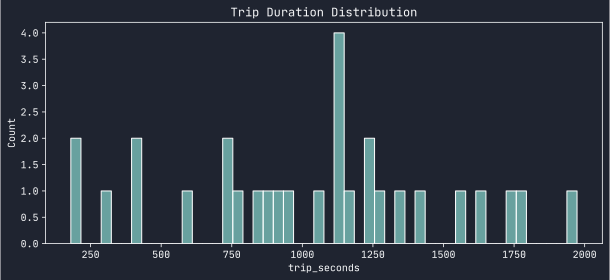

In [14]:
df_sample.info()
df_sample.describe(include='all')
df_sample.isna().sum()

# Example distribution
sns.histplot(df_sample["trip_seconds"], bins=50)
plt.title("Trip Duration Distribution")
plt.show()


#### Temporal Discretization

In [15]:
df_sample['trip_start_timestamp'] = pd.to_datetime(df_sample['trip_start_timestamp'])
df_sample['hour'] = df_sample['trip_start_timestamp'].dt.hour
df_sample['weekday'] = df_sample['trip_start_timestamp'].dt.dayofweek
df_sample['is_weekend'] = df_sample['weekday'] >= 5
df_sample['time_bucket'] = df_sample['hour'] // 4  # 6 slots per day


bucket_labels = [
    "Late Night",    # 0: 00–04
    "Morning Rush",  # 1: 04–08
    "Mid-Morning",   # 2: 08–12
    "Afternoon",     # 3: 12–16
    "Evening Rush",  # 4: 16–20
    "Night"          # 5: 20–24
]
df_sample['time_label'] = df_sample['time_bucket'].map(dict(enumerate(bucket_labels)))


#### Spatial Discretization Using H3

In [17]:
import h3

def point_to_h3(coord, res=8):
    lat, lon = coord[1], coord[0]  # lat/lon order
    return h3.latlng_to_cell(lat, lon, res)

df_sample['h3_pickup'] = df_sample['pickup_centroid_location'].apply(lambda x: point_to_h3(x['coordinates']))
df_sample['h3_dropoff'] = df_sample['dropoff_centroid_location'].apply(lambda x: point_to_h3(x['coordinates']))


In [ ]:
df_sample['geometry_wkt'] = df_sample['geometry'].apply(lambda g: g.wkt if g else None)
df_sample.drop(columns=['geometry'], inplace=True)
df_sample.to_parquet(processed_data_dir / "cleaned_trips.parquet", index=False)
# to reconstruct the geometry
# from shapely import wkt
# df_sample['geometry'] = df_sample['geometry_wkt'].apply(wkt.loads)


In [19]:

df_sample['trip_start_timestamp'] = pd.to_datetime(df_sample['trip_start_timestamp'])
df_sample['trip_hour'] = df_sample['trip_start_timestamp'].dt.floor('h')


historical_df.columns = [col.lower().strip() for col in historical_df.columns]

if 'time' in historical_df.columns:
    historical_df.rename(columns={'time': 'datetime'}, inplace=True)

historical_df['datetime'] = pd.to_datetime(historical_df['datetime'])
historical_df['weather_hour'] = historical_df['datetime'].dt.floor('h')

df_merged = pd.merge(
    df_sample,
    historical_df,
    left_on='trip_hour',
    right_on='weather_hour',
    how='left'
)

df_sample.to_parquet(processed_data_dir / "cleaned_trips.parquet", index=False)
historical_df.to_parquet(processed_data_dir / "cleaned_weather.parquet", index=False)
df_merged.to_parquet(processed_data_dir / "merged_trips_weather.parquet", index=False)

print("✅ Saved: cleaned_trips, cleaned_weather, merged_trips_weather")

✅ Saved: cleaned_trips, cleaned_weather, merged_trips_weather


In [20]:
import pandas as pd

# Load the parquet file
df = pd.read_parquet("data/processed/merged_trips_weather.parquet")

# Export to CSV
df.to_csv("data/processed/merged_trips_weather.csv", index=False)


In [21]:
df

,trip_id,taxi_id,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_community_area,dropoff_community_area,fare,tips,...,geometry_wkt,trip_hour,datetime,temperature_2m,precipitation,weather_code,wind_speed_10m,hour_y,date,weather_hour
0,0a11567bd996c51ac32efbb3e60f923c063aabdc,55ef60184d508809c50a84b8c378a8572fcc0f5bd2ff49...,2025-05-01,2025-05-01 00:00:00,291,1.27,3,6,6.25,0.00,...,"LINESTRING (-87.6558787862 41.96581197, -87.65...",2025-05-01,2025-05-01,12.8,0.0,3,13.1,0,2025-05-01,2025-05-01
1,122e816a1b04575c94de158252e4e3a544b9f900,52c3ffa685a3b5ced3d16461deec5a0326086bee3d8f6a...,2025-05-01,2025-05-01 00:15:00,1733,14.95,76,3,38.75,8.65,...,"LINESTRING (-87.913624596 41.9802643146, -87.6...",2025-05-01,2025-05-01,12.8,0.0,3,13.1,0,2025-05-01,2025-05-01
2,1d17183a28c299443a40163dc3e6d50e10f054f1,d511072131b602026bdb9faa5491d15c3af8d62dc00659...,2025-05-01,2025-05-01 00:00:00,420,3.10,8,32,10.75,0.00,...,"LINESTRING (-87.6333080367 41.899602111, -87.6...",2025-05-01,2025-05-01,12.8,0.0,3,13.1,0,2025-05-01,2025-05-01
3,25264cb08e7db926efd88cab3c35d1df4995e11c,c84c28526a906ef1ad0ea7dc570f97949ecf92dfe156cb...,2025-05-01,2025-05-01 00:15:00,882,7.72,76,17,21.00,0.00,...,"LINESTRING (-87.913624596 41.9802643146, -87.8...",2025-05-01,2025-05-01,12.8,0.0,3,13.1,0,2025-05-01,2025-05-01
4,3592419fe47b3f8b8c6e9df61d50421dd71a32e1,f32c0c8e63d4e5d4bfc7e9d57e5d0f6dcf28450850245d...,2025-05-01,2025-05-01 00:15:00,1560,12.70,76,2,33.25,7.55,...,"LINESTRING (-87.913624596 41.9802643146, -87.6...",2025-05-01,2025-05-01,12.8,0.0,3,13.1,0,2025-05-01,2025-05-01
5,3662c715b13e717144c2d713c31b28000f3232cc,51482afe455eeface5c7492f4dc7638fd2c3a7e10f9174...,2025-05-01,2025-05-01 00:15:00,1415,13.60,56,8,35.00,5.92,...,"LINESTRING (-87.7696154528 41.7925923603, -87....",2025-05-01,2025-05-01,12.8,0.0,3,13.1,0,2025-05-01,2025-05-01
6,3fdaa95736223ad2fadf303e32519742f8970142,d744f003d8f56f6a8b53b97c0589575fa9a975e9d12f66...,2025-05-01,2025-05-01 00:15:00,943,11.66,8,10,29.75,0.00,...,"LINESTRING (-87.6333080367 41.899602111, -87.8...",2025-05-01,2025-05-01,12.8,0.0,3,13.1,0,2025-05-01,2025-05-01
7,420d71c9f73c8b157b83e53a36435339acfef112,34766262f2e312774b1ad4651b99dc23b780dbd00b658f...,2025-05-01,2025-05-01 00:15:00,1254,10.92,56,33,29.50,8.75,...,"LINESTRING (-87.7696154528 41.7925923603, -87....",2025-05-01,2025-05-01,12.8,0.0,3,13.1,0,2025-05-01,2025-05-01
8,445512e4c4cedf6a9280375ac86b1ebea1c97c9b,63d895bf335c522af83a8f2c608e31bb46a5d78cde4df2...,2025-05-01,2025-05-01 00:30:00,1792,18.84,76,8,47.50,0.00,...,"LINESTRING (-87.913624596 41.9802643146, -87.6...",2025-05-01,2025-05-01,12.8,0.0,3,13.1,0,2025-05-01,2025-05-01
9,479fab01d7f75e775296ab6663083b788f340076,b77a2dcc078698ea493d4d703014076e4272dc7d8b420e...,2025-05-01,2025-05-01 00:15:00,1140,14.70,76,22,36.25,5.00,...,"LINESTRING (-87.913624596 41.9802643146, -87.6...",2025-05-01,2025-05-01,12.8,0.0,3,13.1,0,2025-05-01,2025-05-01


## Descriptive Analytics

#### Temporal Demand Patterns (Trips per Hour vs. Day of Week)

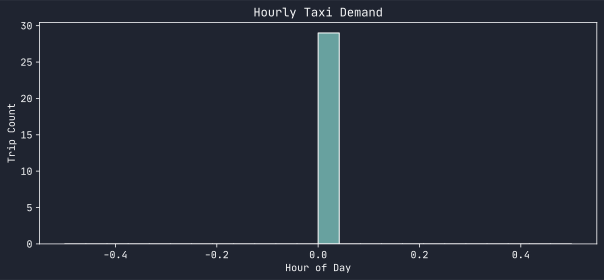

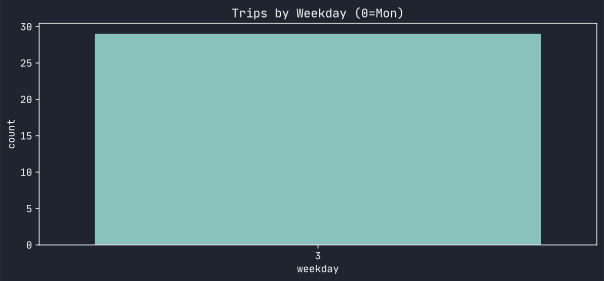

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

# Trips per hour
sns.histplot(df['hour_x'], bins=24)
plt.title("Hourly Taxi Demand")
plt.xlabel("Hour of Day")
plt.ylabel("Trip Count")
plt.show()

# Trips by day of week
sns.countplot(x='weekday', data=df)
plt.title("Trips by Weekday (0=Mon)")
plt.show()


#### Spatial Demand (Trip Count by Pickup H3)

In [24]:
trip_by_h3 = df.groupby('h3_pickup').size().reset_index(name='trip_count')
trip_by_h3.sort_values('trip_count', ascending=False).head(10)


,h3_pickup,trip_count
10,8827593433fffff,11
5,882664c1edfffff,5
0,882664520bfffff,4
3,882664c1a9fffff,2
1,8826645641fffff,1
2,882664c107fffff,1
4,882664c1e1fffff,1
6,882664ca91fffff,1
7,882664cc4dfffff,1
8,882664cd97fffff,1


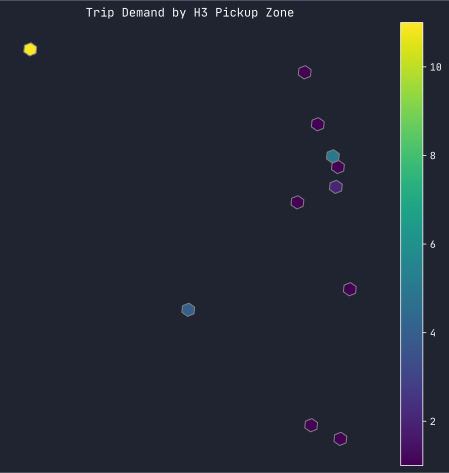

In [31]:
import h3
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon

# Group by H3 pickup
trip_by_h3 = df.groupby('h3_pickup').size().reset_index(name='trip_count')

# ✅ Convert boundary and reformat to (lon, lat)
def h3_to_polygon(h3_index):
    boundary = h3.cell_to_boundary(h3_index)  # Returns list of (lat, lon)
    boundary_lonlat = [(lon, lat) for lat, lon in boundary]
    return Polygon(boundary_lonlat)

trip_by_h3['geometry'] = trip_by_h3['h3_pickup'].apply(h3_to_polygon)

# Create GeoDataFrame
gdf = gpd.GeoDataFrame(trip_by_h3, geometry='geometry', crs='EPSG:4326')

# Plot
fig, ax = plt.subplots(figsize=(10, 8))
gdf.plot(column='trip_count', cmap='viridis', edgecolor='grey', legend=True, ax=ax)
ax.set_title("Trip Demand by H3 Pickup Zone")
ax.set_axis_off()
plt.show()


#### Trip Length - Time - Location

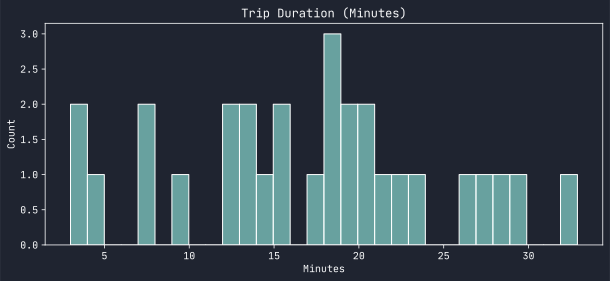

In [32]:
sns.histplot(df['trip_seconds'] / 60, bins=30)
plt.title("Trip Duration (Minutes)")
plt.xlabel("Minutes")
plt.show()


In [33]:
df.groupby('h3_pickup')['trip_miles'].mean().sort_values(ascending=False).head(10)


h3_pickup
882664cc4dfffff    17.710000
882664cd97fffff    13.760000
8827593433fffff    13.620909
8826645641fffff    11.800000
882664c107fffff    10.750000
882664520bfffff    10.272500
882664c1a9fffff     9.120000
882664c1edfffff     6.024000
882664ca91fffff     1.590000
882664d897fffff     1.270000
Name: trip_miles, dtype: float64

In [62]:
# spatial-temporal demand matrix

df['trip_hour'] = pd.to_datetime(df['trip_start_timestamp']).dt.floor('h')
demand_matrix = df.groupby(['trip_hour', 'h3_pickup']).size().unstack(fill_value=0)

plt.figure(figsize=(14, 8))  # Optional: wider plot
sns.heatmap(demand_matrix.T, cmap="YlGnBu", cbar_kws={"label": "Trip Count"})
plt.xlabel("Hour")
plt.ylabel("H3 Pickup Zone")
plt.title("Taxi Demand by Time and H3 Zone")
plt.tight_layout()
plt.show()



ValueError: zero-size array to reduction operation fmin which has no identity

<Figure size 1400x800 with 0 Axes>

#### Pricing Behavior

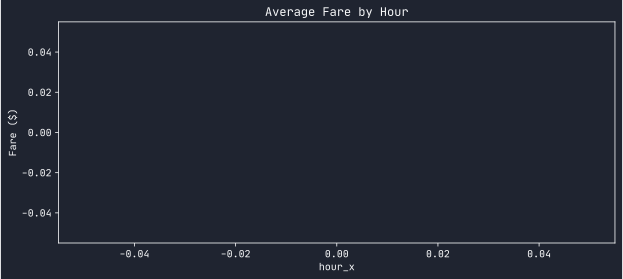

In [57]:
# Average Fare by Hour or Time Bucket
df.groupby('hour_x')['trip_total'].mean().plot()
plt.title("Average Fare by Hour")
plt.ylabel("Fare ($)")
plt.show()



In [35]:
#Tip Rates by Company
df['tip_rate'] = df['tips'] / df['fare']
df.groupby('company')['tip_rate'].mean().sort_values(ascending=False).head(10)


company
Taxicab Insurance Agency Llc    0.270309
Sun Taxi                        0.145781
5 Star Taxi                     0.135220
Taxi Affiliation Services       0.102500
Globe Taxi                      0.056381
Flash Cab                       0.000000
Blue Ribbon Taxi Association    0.000000
City Service                    0.000000
Name: tip_rate, dtype: float64

#### Idle Time Between Trips

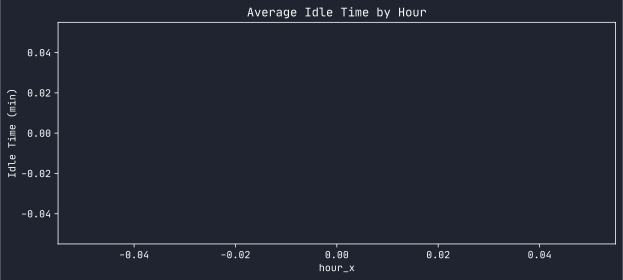

In [36]:
df_sorted = df.sort_values(by=['taxi_id', 'trip_start_timestamp'])
df_sorted['prev_end'] = df_sorted.groupby('taxi_id')['trip_end_timestamp'].shift(1)
df_sorted['idle_time'] = (
    pd.to_datetime(df_sorted['trip_start_timestamp']) -
    pd.to_datetime(df_sorted['prev_end'])
).dt.total_seconds() / 60  # in minutes

# Average idle time by hour
df_sorted.groupby('hour_x')['idle_time'].mean().plot()
plt.title("Average Idle Time by Hour")
plt.ylabel("Idle Time (min)")
plt.show()


#### Weather Impact Analysis

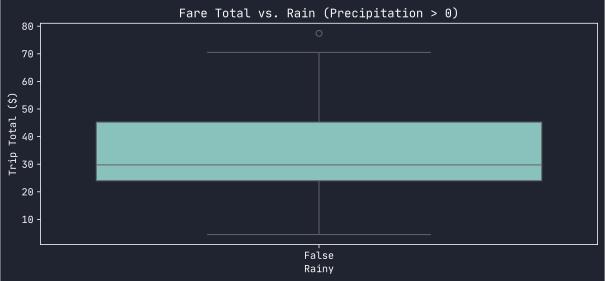

In [43]:
df['is_rainy'] = df['precipitation'] > 0

sns.boxplot(x='is_rainy', y='trip_total', data=df)
plt.title("Fare Total vs. Rain (Precipitation > 0)")
plt.xlabel("Rainy")
plt.ylabel("Trip Total ($)")
plt.show()



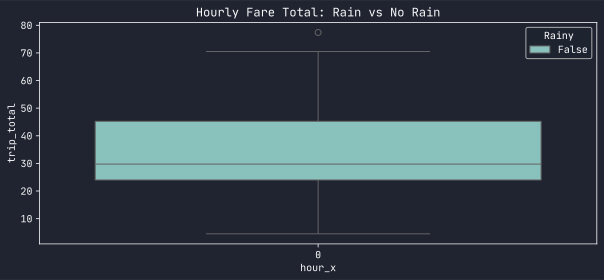

In [44]:
sns.boxplot(x='hour_x', y='trip_total', hue='is_rainy', data=df)
plt.title("Hourly Fare Total: Rain vs No Rain")
plt.legend(title='Rainy')
plt.show()


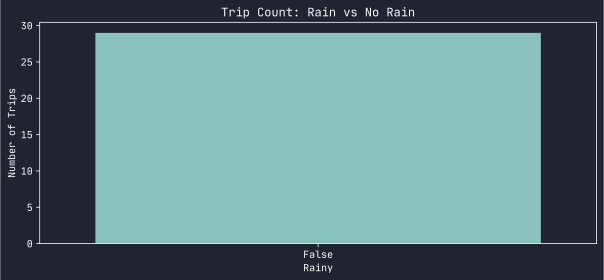

In [45]:
sns.countplot(x='is_rainy', data=df)
plt.title("Trip Count: Rain vs No Rain")
plt.xlabel("Rainy")
plt.ylabel("Number of Trips")
plt.show()


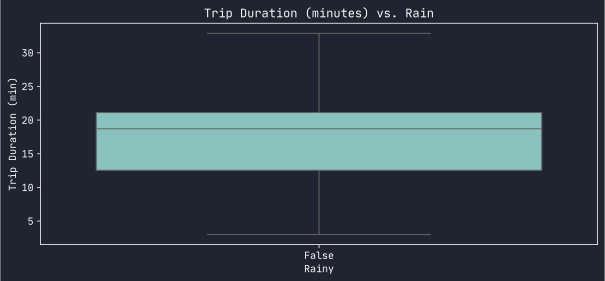

In [46]:
sns.boxplot(x='is_rainy', y=df['trip_seconds'] / 60, data=df)
plt.title("Trip Duration (minutes) vs. Rain")
plt.ylabel("Trip Duration (min)")
plt.xlabel("Rainy")
plt.show()


#### 	GMM Spatial Clustering of Pickups

In [64]:
from sklearn.mixture import GaussianMixture
import numpy as np

# Extracting pickup lat/lon
df['pickup_lon'] = df['pickup_centroid_location'].apply(lambda x: x['coordinates'][0])
df['pickup_lat'] = df['pickup_centroid_location'].apply(lambda x: x['coordinates'][1])
coords = df[['pickup_lat', 'pickup_lon']].dropna().values

n_components = 6  #number of clusters

gmm = GaussianMixture(n_components=n_components, covariance_type='full', random_state=42)
gmm.fit(coords)

# Predict cluster for each pickup
df['gmm_cluster'] = gmm.predict(coords)

# Visualizing clusters
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))
for i in range(n_components):
    cluster_data = df[df['gmm_cluster'] == i]
    plt.scatter(cluster_data['pickup_lon'], cluster_data['pickup_lat'], 
                s=10, label=f"Cluster {i}", alpha=0.5)

plt.legend()
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("GMM Spatial Clusters of Pickup Demand")
plt.grid(True)
plt.show()



ValueError: Found array with 0 sample(s) (shape=(0, 2)) while a minimum of 2 is required by GaussianMixture.

AttributeError: 'GaussianMixture' object has no attribute 'means_'

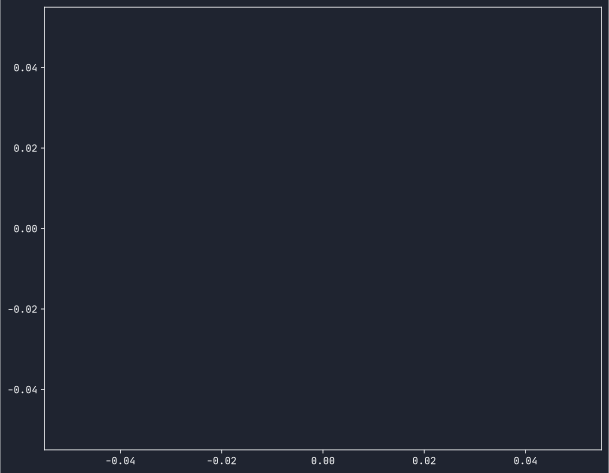

In [65]:
# Gaussian ellipse plotting
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax, **kwargs):
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    ell = Ellipse(position, width, height, angle, **kwargs)
    ax.add_patch(ell)

# Plot with ellipses
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(coords[:, 1], coords[:, 0], s=2, alpha=0.2)

for pos, cov in zip(gmm.means_, gmm.covariances_):
    draw_ellipse(pos[::-1], cov[:2, :2], ax, edgecolor='red', facecolor='none', lw=2)

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("GMM Ellipses over Pickup Hotspots")
plt.grid(True)
plt.show()


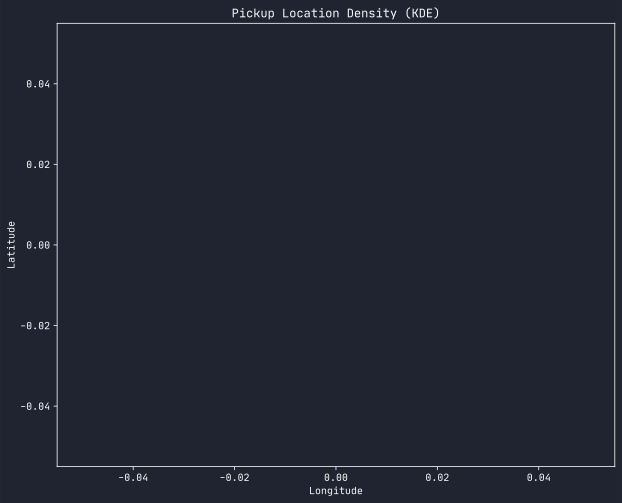

In [66]:
# Kernel Density Estimation (smooth density map)
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.kdeplot(
    x=df['pickup_lon'], y=df['pickup_lat'], 
    cmap="Reds", fill=True, bw_adjust=0.1, levels=100, thresh=0.01
)
plt.title("Pickup Location Density (KDE)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()
